# PCOS - Exploring Predictive Health Factors

## Load Dependencies and Data

### Load Dependencies and Install Other Requirements

In [92]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
import os
from IPython.display import clear_output

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/diet-exercise-and-pcos-insights/Cleaned-Data.csv
/kaggle/input/exploring-predictive-health-factors/sample_submission.csv
/kaggle/input/exploring-predictive-health-factors/train.csv
/kaggle/input/exploring-predictive-health-factors/test.csv


In [93]:
!pip install tabpfn
clear_output(wait=True)
from tabpfn import TabPFNClassifier

print('Installed tapfn')

Installed tapfn


### Load Data
Load test, train, and submission example and make target column ordinal

In [94]:
train = pd.read_csv("/kaggle/input/exploring-predictive-health-factors/train.csv")
add_train = pd.read_csv("/kaggle/input/diet-exercise-and-pcos-insights/Cleaned-Data.csv")
test = pd.read_csv("/kaggle/input/exploring-predictive-health-factors/test.csv")
sample_submission = pd.read_csv("/kaggle/input/exploring-predictive-health-factors/sample_submission.csv")
TARGET = 'PCOS'
train[TARGET] = train[TARGET].map({'Yes': 1, 'No': 0})
print(add_train.PCOS.unique().tolist())
add_train[TARGET] = add_train[TARGET].map({'Yes': 1, 'No': 0, 'No, Yes, not diagnosed by a doctor': 0})
train.head()


['No', 'Yes', 'No, Yes, not diagnosed by a doctor']


,ID,Age,Weight_kg,PCOS,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,Conception_Difficulty,Insulin_Resistance,Exercise_Frequency,Exercise_Type,Exercise_Duration,Sleep_Hours,Exercise_Benefit
0,0,20-25,64.0,0,No,No,No,No,No,Rarely,"Cardio (e.g., running, cycling, swimming)",30 minutes,Less than 6 hours,Somewhat
1,1,15-20,55.0,0,No,No,No,No,No,6-8 Times a Week,No Exercise,Less than 30 minutes,6-8 hours,Somewhat
2,2,15-20,91.0,0,No,No,Yes,No,No,Rarely,"Cardio (e.g., running, cycling, swimming)",Less than 30 minutes,6-8 hours,Somewhat
3,3,15-20,56.0,0,No,No,No,No,No,6-8 Times a Week,"Cardio (e.g., running, cycling, swimming)",45 minutes,6-8 hours,Not at All
4,4,15-20,47.0,0,Yes,No,No,No,No,Rarely,No Exercise,Not Applicable,6-8 hours,Not Much


In [95]:
add_train.head()

,Age,Weight_kg,Height_ft,Marital_Status,PCOS,Family_History_PCOS,Menstrual_Irregularity,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,...,Diet_Multivitamin,Vegetarian,Exercise_Frequency,Exercise_Type,Exercise_Duration,Sleep_Hours,Stress_Level,Smoking,Exercise_Benefit,PCOS_Medication
0,20-25,66.0,157.48,Unmarried,0,No,Yes,No,No,No,...,0,No,Rarely,"Cardio (e.g., running, cycling, swimming)",30 minutes,Less than 6 hours,No,No,Somewhat,No.
1,Less than 20,56.0,165.10,Unmarried,0,No,No,No,No,No,...,0,No,Daily,No Exercise,Less than 30 minutes,6-8 hours,No,No,Somewhat,No.
2,Less than 20,89.0,167.64,Unmarried,0,Yes,No,No,No,Yes,...,0,No,Rarely,"Cardio (e.g., running, cycling, swimming)",Less than 30 minutes,6-8 hours,Yes,No,Somewhat,No.
3,20-25,55.0,160.02,Unmarried,0,Yes,No,Yes,No,Yes,...,1,No,Never,No Exercise,Not Applicable,6-8 hours,Yes,No,Somewhat,No.
4,Less than 20,55.0,160.02,Unmarried,0,No,No,No,No,No,...,0,No,Daily,"Cardio (e.g., running, cycling, swimming)",30 minutes to 1 hour,6-8 hours,Yes,No,Not at All,No.


In [96]:
test.head()

,ID,Age,Weight_kg,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,Conception_Difficulty,Insulin_Resistance,Exercise_Frequency,Exercise_Type,Exercise_Duration,Sleep_Hours,Exercise_Benefit
0,0,20-25,54.0,No,No,No,No,No,Rarely,No Exercise,Less than 30 minutes,6-8 hours,Somewhat
1,1,20-25,65.0,Yes,No,No,No,No,3-4 Times a Week,No Exercise,Not Applicable,6-8 hours,Somewhat
2,2,20-25,64.0,Yes,No,No,No,No,6-8 Times a Week,Cardio (e.g.,Not Applicable,6-8 hours,Somewhat
3,3,Less than 20,57.0,Yes,No,Yes,No,Yes,Rarely,No Exercise,6-8 hours,6-8 hours,Somewhat
4,4,Less than 20,6.0,Yes,No,Yes,No,No,Rarely,Cardio (e.g.,30 minutes,6-8 hours,Somewhat


## EDA

### Feature Extraction

In [97]:
def clean_age_column(age_column):
    cleaned_ages = []
    for age in age_column:
        if pd.isna(age):
            cleaned_ages.append(np.nan)
        elif 'Less than' in age:
            cleaned_ages.append('0-20')
        elif 'and above' in age:
            cleaned_ages.append('45-100')
        elif '-' in age:
            # Handle ranges and ensure they are in proper order
            parts = age.split('-')
            try:
                min_age, max_age = int(parts[0]), int(parts[1])
                if min_age > max_age:
                    min_age, max_age = max_age, min_age
                if max_age <= 20:  # Include anything below or equal to 20 in '<20'
                    cleaned_ages.append('0-20')
                else:
                    cleaned_ages.append(f"{min_age}-{max_age}")
            except ValueError:
                # Handle cases like 'Less than 20-25'
                if 'Less than' in parts[0]:
                    cleaned_ages.append('20-25')
                else:
                    cleaned_ages.append(age)  # Leave as is if it's not fixable
        else:
            cleaned_ages.append(age)  # Leave other cases unchanged
    return cleaned_ages

def normalize_yes_no(column):
    normalized = []
    for value in column:
        if pd.isna(value):  # Handle NaN
            normalized.append(np.nan)
        elif 'Yes' in str(value):  # If 'Yes' is present in the string
            normalized.append('Yes')
        elif 'No' in str(value):  # If 'No' is present but not 'Yes'
            normalized.append('No')
        else:
            normalized.append(value)  # For any unexpected case (shouldn't occur here)
    return normalized

def clean_exercise_column(column):
    replacements = {
        'Rarely': 'Rarely',
        '6-8 Times a Week': '6-8 Times a Week',
        'Never': 'Never',
        '1-2 Times a Week': '1-2 Times a Week',
        '3-4 Times a Week': '3-4 Times a Week',
        '6-8 hours': '3-4 Times a Week',
        'Less than usual': 'Rarely',
        'Less than 6 hours': '1-2 Times a Week'
    }
    
    # Replace using the dictionary and handle NaN values
    return column.map(replacements).fillna('Unknown')

def explode_exercise_types(df, column_name):
    """
    Split and explode the exercise type column to track all individual exercises.

    Args:
        df (pd.DataFrame): The DataFrame containing the column to clean and explode.
        column_name (str): The name of the column to process.

    Returns:
        pd.DataFrame: The DataFrame with one-hot encoded exercises.
    """
    # Step 1: Clean and standardize exercise types
    # Define the replacements based on the first word
    replacements = {
        'Cardio': 'Cardio',
        'Strength': 'Strength Training',
        'Flexibility': 'Flexibility and Balance',
        'High-intensity': 'HIIT',
        'No': 'None',
        None: 'Unknown',
        np.nan: 'Unknown'
    }
    
    # Extract the first word and apply the replacement
    df[column_name] = df[column_name].apply(lambda x: replacements.get(str(x).split()[0], x) if pd.notnull(x) else 'Unknown')
    # Step 2: Split entries containing multiple exercises
    df[column_name] = df[column_name].str.split(', ')
    
    # Step 3: Explode the list of exercises into separate rows
    df_exploded = df.explode(column_name)
    
    # Step 4: One-hot encode the individual exercises
    one_hot = pd.get_dummies(df_exploded[column_name], prefix='', prefix_sep='')
    
    # Step 5: Sum the one-hot encoded values back into the original rows
    df_one_hot = pd.concat([df_exploded[['ID']], one_hot], axis=1).groupby('ID').sum().reset_index()
    
    # Merge back with the original DataFrame (optional)
    df_final = pd.merge(df, df_one_hot, on='ID', how='left').drop(columns=[column_name])
    return df_final


def process_exercise_data(df, column='Exercise_Type', replacements=None):
    """
    Process exercise data with standardized replacements and binary encoding
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    column (str): Target column name
    replacements (dict): Mapping for standardizing exercise types
    
    Returns:
    tuple: (processed DataFrame, list of unique exercises)
    """
    df = df.copy()
    
    if replacements is None:
        replacements = {
            'Cardio': 'Cardio',
            'Strength': 'Strength Training',
            'Flexibility': 'Flexibility and Balance',
            'High-intensity': 'HIIT',
            'Sleep_Benefit': 'Misc',
            'Yes': 'Misc',
            'No': 'None',
            None: 'None',
            np.nan: 'None'
        }
    
    def standardize_and_split(x):
        if pd.isna(x) or x in ['No', 'Somewhat', 'None']:
            return ['None']
        
        x = str(x)
        cleaned = re.sub(r'\s*\([^)]*$', '', x)
        cleaned = re.sub(r'\s*\([^)]*\)', '', cleaned)
        cleaned = re.sub(r'[(),]$', '', cleaned)
        
        items = [item.strip() for item in cleaned.split(',') if item.strip()]
        items = [re.sub(r'\s*\(.*$', '', item).strip() for item in items]
        items = [re.sub(r'\s+$', '', item) for item in items]
        
        # Apply replacements
        standardized = []
        for item in items:
            for key, value in replacements.items():
                if str(key).lower() in item.lower():
                    item = value
                    break
            if item:
                standardized.append(item)
                
        return standardized if standardized else ['None']
    
    # Process exercise types
    exercise_lists = df[column].apply(standardize_and_split)
    
    # Get unique exercises (including 'None')
    all_exercises = sorted(set(
        exercise 
        for sublist in exercise_lists 
        for exercise in sublist
    ))
    
    # Create binary columns
    for exercise in all_exercises:
        df[exercise] = exercise_lists.apply(lambda x: 1 if exercise in x else 0)
    
    # Ensure 'None' is properly encoded
    none_conditions = (
        (df[column].isna()) |
        (df[column] == 'No') |
        (df[column] == 'Somewhat')
    )
    df.loc[none_conditions, 'None'] = 1
    
    return df.drop(columns=[column]), all_exercises

def process_data(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        if col not in ['Exercise_Duration', 'Sleep_Hours', 'Exercise_Benefit']:  
            df[col] = normalize_yes_no(df[col])
        if col == 'Exercise_Frequency':
            df[col] = clean_exercise_column(df[col])
        if col == 'Age':
            df[col] = clean_age_column(df[col])
        if col == 'Exercise_Type':
            #df = explode_exercise_types(df, 'Exercise_Type')
            df, exercise_lists = process_exercise_data(df)
    df['Weight_kg'] = df['Weight_kg'].fillna(df['Weight_kg'].median())
    bins = [20, 40, 50, 60, 70, 80, 90, 100, 120]  # Fixed bin ranges
    bin_labels = [f'Bin {i+1}' for i in range(len(bins)-1)]
    df['weight_bins'] = pd.cut(df['Weight_kg'], bins=bins, labels=bin_labels)    
    df.drop(columns=['Weight_kg'], inplace=True)
    df = df.fillna(df.median(numeric_only=True))  # Fill numeric NaNs with median
    df = df.fillna(df.mode().iloc[0])  # Fill categorical NaNs with mode    
    return df, exercise_lists
    
train, train_exercise_lists = process_data(train)
train.head()
# train.weight_bins.unique().tolist()


,ID,Age,PCOS,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,Conception_Difficulty,Insulin_Resistance,Exercise_Frequency,Exercise_Duration,Sleep_Hours,Exercise_Benefit,Cardio,Flexibility and Balance,HIIT,None,Strength Training,weight_bins
0,0,20-25,0,No,No,No,No,No,Rarely,30 minutes,Less than 6 hours,Somewhat,1,0,0,0,0,Bin 4
1,1,0-20,0,No,No,No,No,No,6-8 Times a Week,Less than 30 minutes,6-8 hours,Somewhat,0,0,0,1,0,Bin 3
2,2,0-20,0,No,No,Yes,No,No,Rarely,Less than 30 minutes,6-8 hours,Somewhat,1,0,0,0,0,Bin 7
3,3,0-20,0,No,No,No,No,No,6-8 Times a Week,45 minutes,6-8 hours,Not at All,1,0,0,0,0,Bin 3
4,4,0-20,0,Yes,No,No,No,No,Rarely,Not Applicable,6-8 hours,Not Much,0,0,0,1,0,Bin 2


### Visualize Features Relative to Target

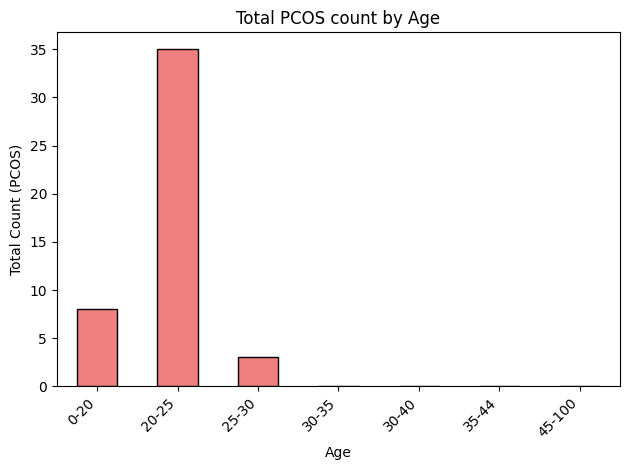

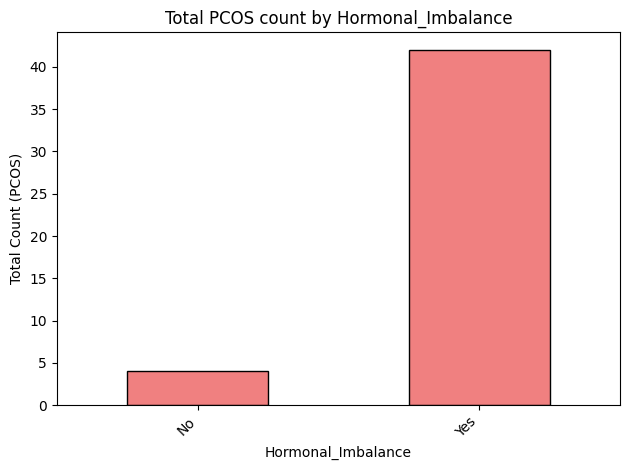

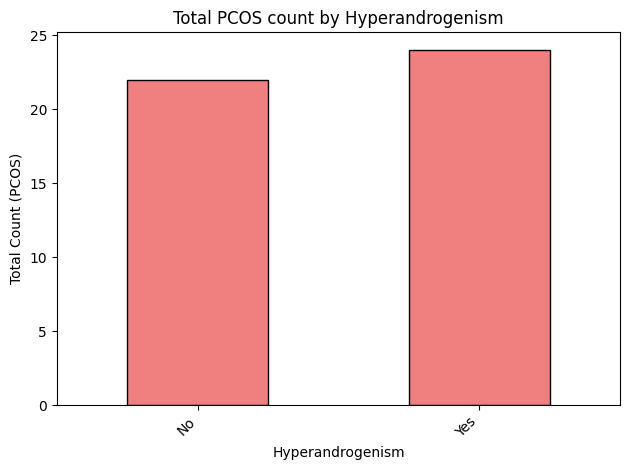

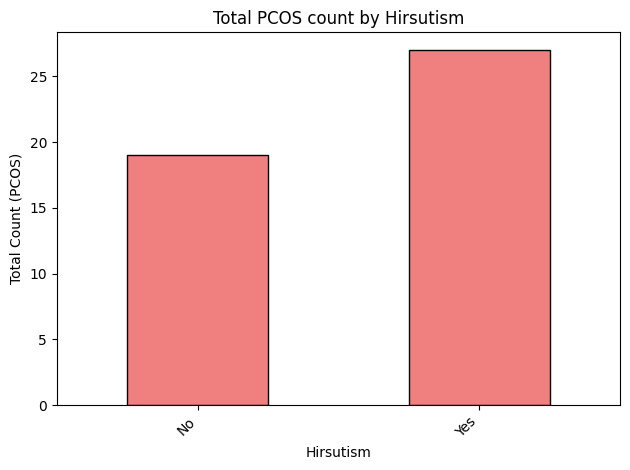

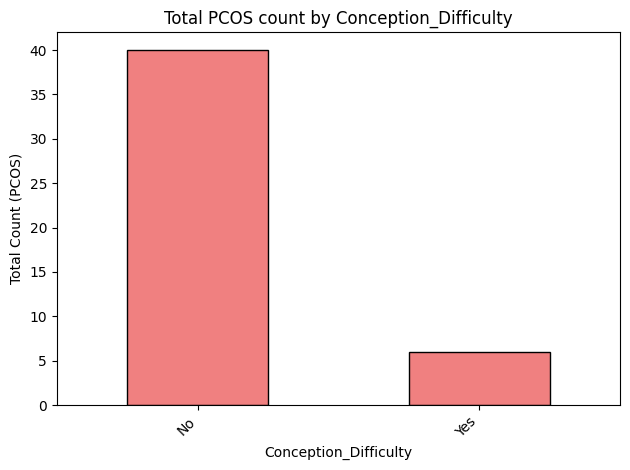

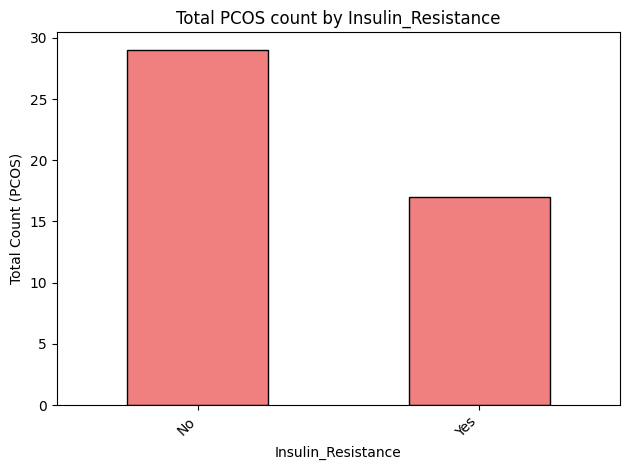

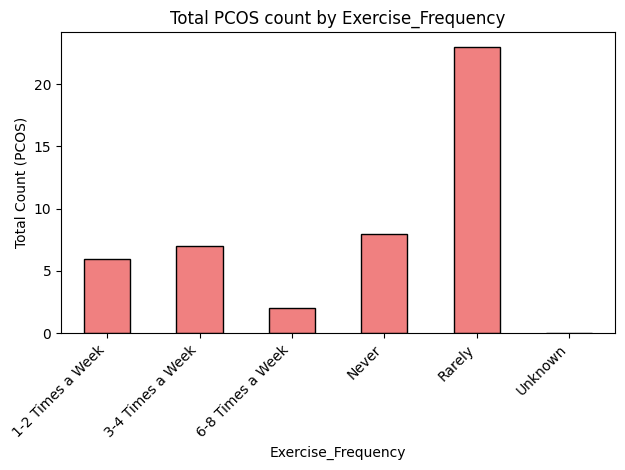

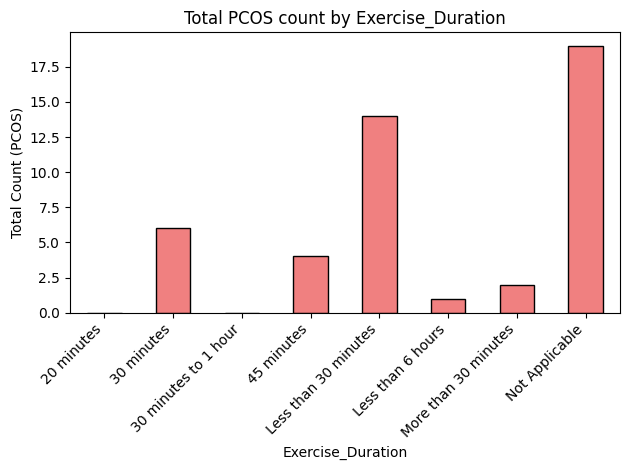

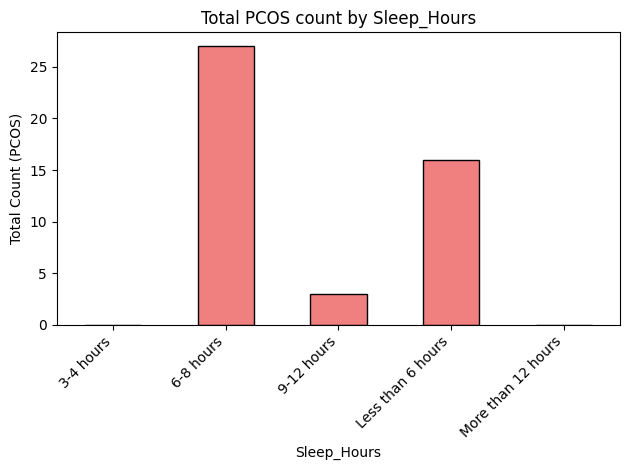

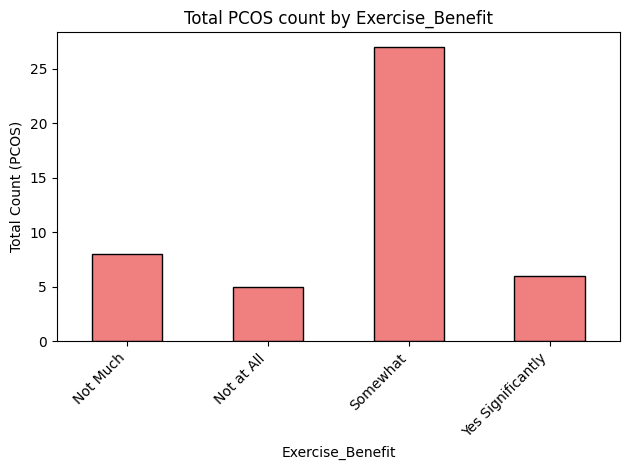

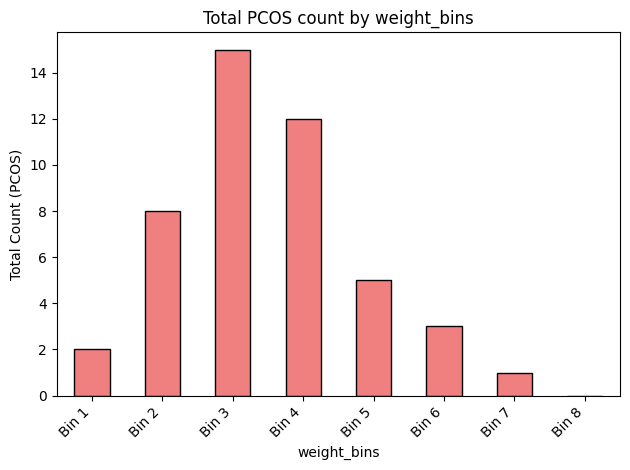

In [98]:
# Plot categorical columns
categorical_cols = train.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    if col not in ['PCOS']:  # Skip num_sold column
        pcos_count = train.groupby(col)['PCOS'].sum()
        pcos_count.plot(kind='bar', color='lightcoral', edgecolor='black')
        plt.title(f'Total PCOS count by {col}')
        plt.xlabel(col)
        plt.ylabel('Total Count (PCOS)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# # Plot numerical columns
# numerical_cols = train.select_dtypes(include=['number']).columns
# for col in numerical_cols:
#     if col not in ['PCOS', 'ID']:  # Skip num_sold column
#         plt.figure(figsize=(8, 6))
#         plt.scatter(train[col], train['PCOS'], alpha=0.6)
#         plt.title(f'{col} vs. PCOS')
#         plt.xlabel(col)
#         plt.ylabel('PCOS')
#         plt.tight_layout()
#         plt.show()

### Examine Feature Usefulness

In [99]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def evaluate_column_usefulness(df, column, target):
    """
    Evaluate the usefulness of a column relative to the target variable.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): The column to evaluate.
        target (str): The target variable.

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    results = {}

    if df[column].dtype in ['int64', 'float64']:  # Numerical feature
        results['Pearson Correlation'] = df[column].corr(df[target], method='pearson')
        results['Spearman Correlation'] = df[column].corr(df[target], method='spearman')
        
        mi = mutual_info_regression(df[[column]], df[target], random_state=42)
        results['Mutual Information'] = mi[0]

    else:  # Categorical feature
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        encoded_column = encoder.fit_transform(df[[column]].fillna("Unknown")).ravel()

        if df[target].dtype in ['int64', 'float64']:
            mi = mutual_info_regression(encoded_column.reshape(-1, 1), df[target], random_state=42)
        else:
            mi = mutual_info_classif(encoded_column.reshape(-1, 1), df[target], random_state=42)

        results['Mutual Information'] = mi[0]
        results['Cramér’s V'] = cramers_v(df[column].fillna("Unknown"), df[target])

        # Chi-Squared Test
        contingency_table = pd.crosstab(df[column].fillna('Unknown'), df[target])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        results['Chi-Squared Statistic'] = chi2
        results['p-value'] = p

    return results

def feature_selection_old(df, target, categorical_cols, numerical_cols, mi_threshold_percentile=10):
    """
    Selects relevant features using correlation, mutual information, and Cramér’s V.

    Args:
        df (pd.DataFrame): DataFrame containing the dataset.
        target (str): The target variable.
        categorical_cols (list): List of categorical feature column names.
        numerical_cols (list): List of numerical feature column names.
        mi_threshold_percentile (int): Percentile below which features are dropped.

    Returns:
        pd.DataFrame: DataFrame with selected features.
    """
    mi_scores = []
    
    for col in categorical_cols + numerical_cols:
        results = evaluate_column_usefulness(df, col, target)
        mi_scores.append((col, results.get('Mutual Information', 0)))
        print(f"Usefulness of '{col}' relative to '{target}':\n", results)

    # Determine dynamic threshold (bottom X% of MI scores)
    mi_scores = sorted(mi_scores, key=lambda x: x[1])  # Sort by MI value
    threshold = np.percentile([score for _, score in mi_scores], mi_threshold_percentile)

    # Drop low-relevance features
    drop = [col for col, score in mi_scores if score < threshold]
    df = df.drop(columns=drop)

    print(f"\n🚀 Dropped {len(drop)} columns: {drop}")
    
    return df, drop


In [100]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import spearmanr

def feature_selection(df, target, categorical_cols, numerical_cols, mi_threshold_percentile=10):
    """
    Selects relevant features using Mutual Information (MI) for categorical and Spearman correlation for numerical.

    Args:
        df (pd.DataFrame): Dataset.
        target (str): Target variable.
        categorical_cols (list): List of categorical column names.
        numerical_cols (list): List of numerical column names.
        mi_threshold_percentile (int): Percentile threshold for MI-based feature selection.

    Returns:
        pd.DataFrame: DataFrame with selected features.
        list: Dropped feature names.
    """
    scores = []
    # Mutual Information for categorical features
    for col in categorical_cols:
        mi = mutual_info_classif(df[[col]], df[target], discrete_features=True)[0]
        scores.append((col, mi))

    # Spearman correlation for numerical features
    for col in numerical_cols:
        spearman_corr, _ = spearmanr(df[col], df[target])
        scores.append((col, abs(spearman_corr)))  # Take absolute value for selection

    # Dynamic threshold based on MI/Spearman scores
    scores = sorted(scores, key=lambda x: x[1])  # Sort by score
    threshold = np.percentile([s for _, s in scores], mi_threshold_percentile)

    # Drop low-relevance features
    drop = [col for col, score in scores if score < threshold]
    #df = df.drop(columns=drop)

    print(f"\n🚀 Dropped {len(drop)} columns: {drop}")
    
    return drop

In [101]:
def ohe_bool(df, ohe):
    # One-hot encode categorical columns if `ohe` is True
    if ohe:
        # Select categorical columns for one-hot encoding
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        # Perform one-hot encoding
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
    
    # Convert boolean columns to integers
    for col in df.columns:
        if df[col].dtype == bool:
            df[col] = df[col].astype(int)
    df.columns = df.columns.str.replace(r'[^A-Za-z0-9_]', '_', regex=True)
    if "ID" in df.columns.tolist():
        df.drop(columns=['ID'], inplace=True)
    
    return df

data = ohe_bool(train, True)
# Fill missing values with median (numerical) or mode (categorical)
data.head()

,PCOS,Cardio,Flexibility_and_Balance,HIIT,None,Strength_Training,Age_0_20,Age_20_25,Age_25_30,Age_30_35,...,Exercise_Benefit_Somewhat,Exercise_Benefit_Yes_Significantly,weight_bins_Bin_1,weight_bins_Bin_2,weight_bins_Bin_3,weight_bins_Bin_4,weight_bins_Bin_5,weight_bins_Bin_6,weight_bins_Bin_7,weight_bins_Bin_8
0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [102]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
examine_data = data.copy()
examine_data[categorical_cols] = encoder.fit_transform(examine_data[categorical_cols])
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

drop = feature_selection(examine_data, target=TARGET, 
                          categorical_cols=categorical_cols, 
                          numerical_cols=numerical_cols,
                          mi_threshold_percentile=0)

for col in data.columns.tolist():
    if '_no' in col.lower():
        drop.append(col)
data = data.drop(columns=drop)
features = data.columns.tolist()
print(f"\nRemaining features: {features}")

Numerical Columns: ['PCOS', 'Cardio', 'Flexibility_and_Balance', 'HIIT', 'None', 'Strength_Training', 'Age_0_20', 'Age_20_25', 'Age_25_30', 'Age_30_35', 'Age_30_40', 'Age_35_44', 'Age_45_100', 'Hormonal_Imbalance_No', 'Hormonal_Imbalance_Yes', 'Hyperandrogenism_No', 'Hyperandrogenism_Yes', 'Hirsutism_No', 'Hirsutism_Yes', 'Conception_Difficulty_No', 'Conception_Difficulty_Yes', 'Insulin_Resistance_No', 'Insulin_Resistance_Yes', 'Exercise_Frequency_1_2_Times_a_Week', 'Exercise_Frequency_3_4_Times_a_Week', 'Exercise_Frequency_6_8_Times_a_Week', 'Exercise_Frequency_Never', 'Exercise_Frequency_Rarely', 'Exercise_Frequency_Unknown', 'Exercise_Duration_20_minutes', 'Exercise_Duration_30_minutes', 'Exercise_Duration_30_minutes_to_1_hour', 'Exercise_Duration_45_minutes', 'Exercise_Duration_Less_than_30_minutes', 'Exercise_Duration_Less_than_6_hours', 'Exercise_Duration_More_than_30_minutes', 'Exercise_Duration_Not_Applicable', 'Sleep_Hours_3_4_hours', 'Sleep_Hours_6_8_hours', 'Sleep_Hours_9_12

In [103]:
add_data, add_features = process_data(add_train)
add_data = ohe_bool(add_train, True)
drop = []
for col in add_data.columns.tolist():
    if col not in features:
        drop.append(col)
add_data.drop(columns=drop, inplace=True)
data_features = set(data.columns)
add_data_features = set(add_data.columns)

# Identify missing columns
missing_cols = list(data_features - add_data_features)
# Add missing columns in one step
if missing_cols:
    add_data = pd.concat([add_data, pd.DataFrame(0, index=add_data.index, columns=missing_cols)], axis=1)
drop = []
for col in add_data.columns.tolist():
    if col not in data.columns.tolist():
        drop.append(col)
add_data.head()


,PCOS,Age_0_20,Age_20_25,Age_25_30,Age_30_35,Age_35_44,Age_45_100,Hormonal_Imbalance_Yes,Hyperandrogenism_Yes,Hirsutism_Yes,...,weight_bins_Bin_7,Flexibility_and_Balance,None,Strength_Training,Cardio,Age_30_40,Exercise_Duration_45_minutes,Exercise_Duration_20_minutes,weight_bins_Bin_5,Exercise_Frequency_6_8_Times_a_Week
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
comb_data = pd.concat([data, add_data])
comb_data.dropna(subset=[TARGET], inplace=True)
comb_data.to_csv("combined_data.csv")
print(f"Total data count = {len(comb_data)} = training data ({len(data)}) + additional data ({len(add_data)})")
feats = ['PCOS', 'Hyperandrogenism_Yes',
'Age_25_30',
'Hormonal_Imbalance_Yes',
'Insulin_Resistance_Yes',  
'Sleep_Hours_9_12_hours',   
'Age_0_20',
'Exercise_Duration_45_minutes',
'Exercise_Frequency_Rarely',
'Sleep_Hours_6_8_hours',                       
'Hirsutism_Yes',
'Exercise_Benefit_Somewhat',
'Conception_Difficulty_Yes',   
'Exercise_Duration_Less_than_30_minutes',
'Sleep_Hours_Less_than_6_hours']
for col in comb_data:
    if col not in feats:
        drop.append(col)
comb_data.drop(columns=drop, inplace=True)
comb_data.head()

Total data count = 383 = training data (210) + additional data (173)


,PCOS,Age_0_20,Age_25_30,Hormonal_Imbalance_Yes,Hyperandrogenism_Yes,Hirsutism_Yes,Conception_Difficulty_Yes,Insulin_Resistance_Yes,Exercise_Frequency_Rarely,Exercise_Duration_45_minutes,Exercise_Duration_Less_than_30_minutes,Sleep_Hours_6_8_hours,Sleep_Hours_9_12_hours,Sleep_Hours_Less_than_6_hours,Exercise_Benefit_Somewhat
0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1
2,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1
3,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
4,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0


## Best Parameter Research

In [105]:
rf_n_trials = 10
n_trials = 100

### XGBoost Optuna

In [106]:
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

class XGBoostOptimizer:
    def __init__(self, data, target_column, test_size=0.2, random_state=42):
        """
        Initialize the optimizer with data and splitting parameters
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input DataFrame containing features and target
        target_column : str
            Name of the target column
        test_size : float
            Proportion of data to use for testing
        random_state : int
            Random seed for reproducibility
        """
        self.data = data
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        # Split the data
        self._split_data()
    
    def _split_data(self):
        """Split the data into training and testing sets"""
        y = self.data[self.target_column]
        X = self.data.drop(columns=[self.target_column])
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y
        )
    
    def objective(self, trial):
        """Optuna objective function for optimizing XGBoost hyperparameters"""
        param = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
            'random_state': self.random_state
        }
        
        model = xgb.XGBClassifier(**param)
        
        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            scores = cross_val_score(
                model,
                self.X_train,
                self.y_train,
                cv=kf,
                scoring='accuracy'
            )
        
        return scores.mean()
    
    def train_and_evaluate(self, best_params):
        """Train and evaluate XGBoost model with best parameters"""
        model = xgb.XGBClassifier(**best_params)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(
                self.X_train,
                self.y_train,
                eval_set=[(self.X_test, self.y_test)],
                early_stopping_rounds=50,
                verbose=False
            )
        
        results = {}
        y_pred = model.predict(self.X_test)
        results['accuracy'] = accuracy_score(self.y_test, y_pred)
        results['classification_report'] = classification_report(self.y_test, y_pred)
        
        return model, results
    
    
    
# Example usage
if __name__ == "__main__":
    optimizer = XGBoostOptimizer(
        data=comb_data,
        target_column=TARGET,
        test_size=0.2,
        random_state=42
    )
    
    best_model, study, results = optimizer.optimize(n_trials=n_trials)
    xgb_params = study.best_trial.params
    # Print optimization summary
    print("\nBest trial:")
    print("  Value:", study.best_trial.value)
    print("  Params:", xgb_params)
    
    # # Access train/test splits if needed
    # X_train = optimizer.X_train
    # X_test = optimizer.X_test
    # y_train = optimizer.y_train
    # y_test = optimizer.y_test

Optimizing XGBoost:   0%|          | 0/100 [00:00<?, ?it/s]


Best trial:
  Value: 0.8821787414066632
  Params: {'max_depth': 7, 'learning_rate': 0.11969944069106989, 'n_estimators': 235, 'min_child_weight': 1, 'gamma': 0.2532575970304375, 'subsample': 0.8412142504853894, 'colsample_bytree': 0.9049872692090837, 'reg_alpha': 0.26441113593846616, 'reg_lambda': 0.7288912332526809}


### LGBM Optuna

In [107]:
import numpy as np
import pandas as pd

import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
import warnings
from tqdm.auto import tqdm
import logging
import sys

# Suppress all warnings and logging
warnings.filterwarnings('ignore')
logging.getLogger('lightgbm').setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.ERROR)

class LGBMOptimizer:
    def __init__(self, data, target_column, test_size=0.2, random_state=42):
        self.data = data
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self._split_data()
    
    def _split_data(self):
        y = self.data[self.target_column]
        X = self.data.drop(columns=[self.target_column])
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y
        )
    
    def objective(self, trial):
        param = {
            # Core Parameters
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),  # Removed GOSS
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            
            # Regularization and Control Parameters
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            
            # Additional Parameters
            'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
            'max_bin': trial.suggest_int('max_bin', 200, 300),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            
            # Fixed Parameters
            'random_state': self.random_state,
            'verbose': -1,
            'force_col_wise': True
        }
        
        # Special handling for DART mode
        if param['boosting_type'] == 'dart':
            param['drop_rate'] = trial.suggest_float('drop_rate', 0.1, 0.5)
            param['skip_drop'] = trial.suggest_float('skip_drop', 0.1, 0.5)
            param['max_drop'] = trial.suggest_int('max_drop', 10, 50)
        
        model = lgb.LGBMClassifier(**param)
        
        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)
        scores = cross_val_score(
            model,
            self.X_train,
            self.y_train,
            cv=kf,
            scoring='accuracy'
        )
        
        return scores.mean()
    
    def train_and_evaluate(self, best_params):
        model = lgb.LGBMClassifier(**best_params)
        
        model.fit(
            self.X_train,
            self.y_train,
            eval_set=[(self.X_test, self.y_test)],
            eval_metric='logloss',  # <-- Add this
            # early_stopping_rounds=50,
            # verbose=False
        )
        
        results = {}
        y_pred = model.predict(self.X_test)
        results['accuracy'] = accuracy_score(self.y_test, y_pred)
        results['classification_report'] = classification_report(self.y_test, y_pred)
        
        return model, results
    
    def optimize(self, n_trials=100):
        study = optuna.create_study(direction='maximize')
        
        # Create progress bar
        with tqdm(total=n_trials, desc="Optimizing LGBM") as pbar:
            def objective_with_progress(trial):
                value = self.objective(trial)
                pbar.update(1)
                return value
                
            study.optimize(objective_with_progress, n_trials=n_trials)
        
        best_model, results = self.train_and_evaluate(study.best_params)
        
        return best_model, study, results

# Example usage
if __name__ == "__main__":
    optimizer = LGBMOptimizer(
        data=comb_data,
        target_column=TARGET,
        test_size=0.2,
        random_state=42
    )
    
    best_model, study, results = optimizer.optimize(n_trials=n_trials)
    lgbm_params = study.best_trial.params
    # Print optimization summary
    print("\nBest trial:")
    print("  Value:", study.best_trial.value)
    print("  Params:", lgbm_params)
    
    # # Access train/test splits if needed
    # X_train = optimizer.X_train
    # X_test = optimizer.X_test
    # y_train = optimizer.y_train
    # y_test = optimizer.y_test

Optimizing LGBM:   0%|          | 0/100 [00:00<?, ?it/s]


Best trial:
  Value: 0.8756213643574828
  Params: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': 7, 'learning_rate': 0.058396356505421645, 'n_estimators': 261, 'min_child_samples': 93, 'min_child_weight': 1.8490338811341365, 'subsample': 0.8436044453030731, 'colsample_bytree': 0.837626666635741, 'reg_alpha': 1.8492565641199275e-08, 'reg_lambda': 0.11864944794498603, 'min_split_gain': 0.3003324841430127, 'max_bin': 297, 'min_data_in_leaf': 22, 'feature_fraction': 0.6780510444839956, 'bagging_fraction': 0.8887207031389379, 'bagging_freq': 7}


### Random Forests Optuna

In [108]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
import warnings
from tqdm.auto import tqdm
import logging
import sys

# Suppress all warnings and logging
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

class RFOptimizer:
    def __init__(self, data, target_column, test_size=0.2, random_state=42):
        self.data = data
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self._split_data()
    
    def _split_data(self):
        y = self.data[self.target_column]
        X = self.data.drop(columns=[self.target_column])
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y
        )
    
    def objective(self, trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "random_state": self.random_state
        }
        

        model = RandomForestClassifier(**params)
        
        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)
        scores = cross_val_score(
            model,
            self.X_train,
            self.y_train,
            cv=kf,
            scoring='accuracy'
        )
        
        return scores.mean()
    
    def train_and_evaluate(self, best_params):
        model = RandomForestClassifier(**best_params)
        
        model.fit(
            self.X_train,
            self.y_train,
        )
        
        results = {}
        y_pred = model.predict(self.X_test)
        results['accuracy'] = accuracy_score(self.y_test, y_pred)
        results['classification_report'] = classification_report(self.y_test, y_pred)
        
        return model, results
    
    def optimize(self, n_trials=100):
        study = optuna.create_study(direction='maximize')
        
        # Create progress bar
        with tqdm(total=n_trials, desc="Optimizing RF") as pbar:
            def objective_with_progress(trial):
                value = self.objective(trial)
                pbar.update(1)
                return value
                
            study.optimize(objective_with_progress, n_trials=n_trials)
        
        best_model, results = self.train_and_evaluate(study.best_params)
        
        return best_model, study, results

# Example usage
if __name__ == "__main__":
    optimizer = RFOptimizer(
        data=data,
        target_column=TARGET,
        test_size=0.2,
        random_state=42
    )
    
    best_model, study, results = optimizer.optimize(n_trials=rf_n_trials)
    rf_params = study.best_trial.params
    # Print optimization summary
    print("\nBest trial:")
    print("  Value:", study.best_trial.value)
    print("  Params:", rf_params)
    
    # Access train/test splits if needed
    X_train = optimizer.X_train
    X_test = optimizer.X_test
    y_train = optimizer.y_train
    y_test = optimizer.y_test

Optimizing RF:   0%|          | 0/10 [00:00<?, ?it/s]


Best trial:
  Value: 0.8329768270944742
  Params: {'n_estimators': 150, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True}


In [109]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np

def extended_classification_report(y_true, y_pred):
    """
    Generates a classification report and adds AUROC if probabilities are provided.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.

    Returns:
        dict: Classification report dictionary with AUROC (if applicable).
    """
    # Generate standard classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Compute accuracy
    report['accuracy'] = accuracy_score(y_true, y_pred)

    # Compute AUROC if probability scores are provided
    try:
        if len(np.unique(y_true)) == 2:  # Binary classification
            auroc = roc_auc_score(y_true, y_pred)
        else:  # Multiclass classification (one-vs-rest AUROC)
            auroc = roc_auc_score(y_true, y_pred, multi_class="ovr")
        
        report['AUROC'] = auroc
    except Exception as e:
        report['AUROC'] = f"Error computing AUROC: {str(e)}"
    
    return report


In [110]:
import pickle
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import numpy as np

print(f"Features model is training on: {comb_data.columns.tolist()}")

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
Y = comb_data[TARGET]
X = comb_data.drop(columns=[TARGET])
models = []
scores = []
# for col in features:
#     print(f"{col}: {comb_data[col].unique().tolist()}")
for fold, (X_train_idx, X_test_idx) in enumerate(skf.split(X,Y)):
    X_train = X.iloc[X_train_idx]
    X_test = X.iloc[X_test_idx]
    y_train = Y.iloc[X_train_idx]
    y_test = Y.iloc[X_test_idx]

    from sklearn.ensemble import VotingClassifier
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb.XGBClassifier(**xgb_params)),
            ('lgbm', lgb.LGBMClassifier(**lgbm_params)),
            ('rf', RandomForestClassifier(**rf_params)),
            ('logreg', LogisticRegression()),
            ('tabfin', TabPFNClassifier(random_state=42))
        ],
        voting='soft'  # 'soft' for probabilities, 'hard' for majority vote
    )
    

    
    # Train the model on the training data
    ensemble.fit(X_train, y_train)
    # Make predictions on the test data
    y_pred = ensemble.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test.tolist(), y_pred)  # Mean Squared Error
    #score = mape(y_test.tolist(), y_pred)
    r2 = r2_score(y_test.tolist(), y_pred)  # R-squared score
    models.append(ensemble)
    report = extended_classification_report(y_test, y_pred)
    scores.append(report['AUROC'])
    print(f"\nFold {fold+1} Results")
    print(y_test.tolist()[:5])
    print(y_pred[:5])
    print(f"AUROC: {scores [len(scores)-1]:.4f}")
    # print("\nClassification Report:\n", report)
    # break

Features model is training on: ['PCOS', 'Age_0_20', 'Age_25_30', 'Hormonal_Imbalance_Yes', 'Hyperandrogenism_Yes', 'Hirsutism_Yes', 'Conception_Difficulty_Yes', 'Insulin_Resistance_Yes', 'Exercise_Frequency_Rarely', 'Exercise_Duration_45_minutes', 'Exercise_Duration_Less_than_30_minutes', 'Sleep_Hours_6_8_hours', 'Sleep_Hours_9_12_hours', 'Sleep_Hours_Less_than_6_hours', 'Exercise_Benefit_Somewhat']

Fold 1 Results
[0, 1, 0, 0, 0]
[0 1 0 0 0]
AUROC: 0.9278

Fold 2 Results
[0, 0, 0, 0, 0]
[0 0 0 0 0]
AUROC: 0.9278

Fold 3 Results
[0, 0, 0, 0, 0]
[0 0 0 0 0]
AUROC: 0.7778

Fold 4 Results
[0, 0, 0, 0, 0]
[0 0 0 0 0]
AUROC: 0.8583

Fold 5 Results
[1, 1, 0, 0, 0]
[1 1 0 0 0]
AUROC: 0.7167

Fold 6 Results
[0, 1, 0, 0, 0]
[0 0 0 0 0]
AUROC: 0.6083

Fold 7 Results
[1, 0, 0, 0, 0]
[1 0 0 0 0]
AUROC: 0.7792

Fold 8 Results
[1, 0, 0, 0, 0]
[1 0 0 0 1]
AUROC: 0.6375

Fold 9 Results
[0, 1, 0, 0, 0]
[0 0 0 0 0]
AUROC: 0.6875

Fold 10 Results
[0, 0, 0, 0, 1]
[0 0 0 0 0]
AUROC: 0.6877


In [111]:
# Threshold calculation
threshold = max(scores) - 0.15

# Get indices of values less than threshold
indices_to_remove = [i for i, value in enumerate(scores) if value < threshold]
print(f"Dropping {len(indices_to_remove)} models from ensemble due to poor performance.")
# Remove items at those indices from the other list
models = [item for i, item in enumerate(models) if i not in indices_to_remove]
#print(models)

Dropping 5 models from ensemble due to poor performance.


## Prediction

In [112]:
df_test, test_exercise_lists = process_data(test)
df_clean_test = ohe_bool(df_test, True)

assert(len(test) == len(df_clean_test))
train_features = set(X_train.columns)
test_features = set(df_clean_test.columns)

# Identify missing columns
missing_cols = list(train_features - test_features)
# Add missing columns in one step
if missing_cols:
    df_clean_test = pd.concat([df_clean_test, pd.DataFrame(0, index=df_clean_test.index, columns=missing_cols)], axis=1)
drop = []
for col in df_clean_test.columns.tolist():
    if col not in X.columns.tolist():
        drop.append(col)
df_clean_test.drop(columns=drop, inplace=True)
print(df_clean_test.columns.tolist())
# Drop extra columns and ensure column order matches training data
df_clean_test = df_clean_test[X.columns]

# Make predictions with all models and ensemble
test_preds = pd.DataFrame()
for i, model in enumerate(models, start=1):
    test_preds[i] = model.predict(df_clean_test)
    print(f"Model {i} prediction complete.")
# print(test_preds.iloc[:, 0].unique().tolist())
# Average predictions (ensemble)
ensemble_preds = test_preds.mean(axis=1)
print(ensemble_preds)
# Prepare submission
submission = pd.DataFrame()
submission['ID'] = df_test['ID']
submission[TARGET] = ensemble_preds 
# submission[TARGET] = np.where(ensemble_preds >= 0.5, 1, 0)
submission.columns = sample_submission.columns 
submission.to_csv('submission.csv', index=False)

submission

['Age_0_20', 'Hormonal_Imbalance_Yes', 'Hyperandrogenism_Yes', 'Hirsutism_Yes', 'Conception_Difficulty_Yes', 'Insulin_Resistance_Yes', 'Exercise_Frequency_Rarely', 'Exercise_Duration_Less_than_30_minutes', 'Sleep_Hours_6_8_hours', 'Sleep_Hours_9_12_hours', 'Sleep_Hours_Less_than_6_hours', 'Exercise_Benefit_Somewhat', 'Age_25_30', 'Exercise_Duration_45_minutes']
Model 1 prediction complete.
Model 2 prediction complete.
Model 3 prediction complete.
Model 4 prediction complete.
Model 5 prediction complete.
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
140    0.0
141    0.0
142    1.0
143    0.0
144    0.0
Length: 145, dtype: float64


,ID,PCOS
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
140,140,0.0
141,141,0.0
142,142,1.0
143,143,0.0


In [113]:
submission.PCOS.value_counts()

PCOS
0.0    129
1.0     16
Name: count, dtype: int64

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

def train_and_evaluate_models(data):
    # Separate features and target
    X = data.drop('PCOS', axis=1)
    y = data['PCOS']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize models
    models = {
        'xgb': xgb.XGBClassifier(random_state=42, n_estimators=100),
        'lgbm': lgb.LGBMClassifier(random_state=42, n_estimators=100),
        'rf': RandomForestClassifier(random_state=42, n_estimators=100),
        'logreg': LogisticRegression(random_state=42, max_iter=1000),
        'tabfin': TabPFNClassifier(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
        
        results[name] = {
            'Classification Report': classification_report(y_test, y_pred),
            'Cross-val ROC-AUC': np.mean(cv_scores),
            'Cross-val STD': np.std(cv_scores)
        }
        
        # For Random Forest, get feature importance
        if name in ['xgb', 'lgbm', 'rf']:
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            results[name]['Feature Importance'] = feature_importance
    
    return results, models


results, trained_models = train_and_evaluate_models(comb_data)

def print_results(results):
    for model_name, metrics in results.items():
        print(f"\n{model_name} Results:")
        print("-" * 50)
        print(f"Classification Report:\n{metrics['Classification Report']}")
        print(f"Cross-validation ROC-AUC: {metrics['Cross-val ROC-AUC']:.3f} (±{metrics['Cross-val STD']:.3f})")
        
        if 'Feature Importance' in metrics:
            print("\nTop 10 Most Important Features:")
            print(metrics['Feature Importance'].head(10))
print_results(results)


xgb Results:
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93        61
           1       0.71      0.75      0.73        16

    accuracy                           0.88        77
   macro avg       0.82      0.83      0.83        77
weighted avg       0.89      0.88      0.88        77

Cross-validation ROC-AUC: 0.930 (±0.061)

Top 10 Most Important Features:
                          feature  importance
3            Hyperandrogenism_Yes    0.392658
2          Hormonal_Imbalance_Yes    0.146943
6          Insulin_Resistance_Yes    0.109615
8    Exercise_Duration_45_minutes    0.078624
11         Sleep_Hours_9_12_hours    0.061721
12  Sleep_Hours_Less_than_6_hours    0.042964
0                        Age_0_20    0.033675
7       Exercise_Frequency_Rarely    0.030470
10          Sleep_Hours_6_8_hours    0.027733
13      Exercise_Benefit_Somewhat    0.026578

lgbm